<h1> CIFAR10 DNN for Image Classification </h1>
<p> This notebook is a simple example of how to use the CIFAR10 dataset to train a DNN for image classification. </p>
<p> We are goin to use the <a href="https://www.cs.toronto.edu/~kriz/cifar.html">CIFAR10</a> dataset, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. </p>
<p> The dataset is divided in 50000 training images and 10000 test images. </p>
<p> The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. </p>
<p> The dataset is already included in Keras, so we just need to import it. </p>


<h2> Importing Libraries </h2>


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.constraints import max_norm as maxnorm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import os
import time


<h2> Loading the Dataset </h2>

In [48]:
data = cifar10.load_data()


In [49]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [50]:
np.random.seed(42) # 42 is the answer to everything

/Users/amraly/anaconda3/envs/ML/lib/python3.11/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


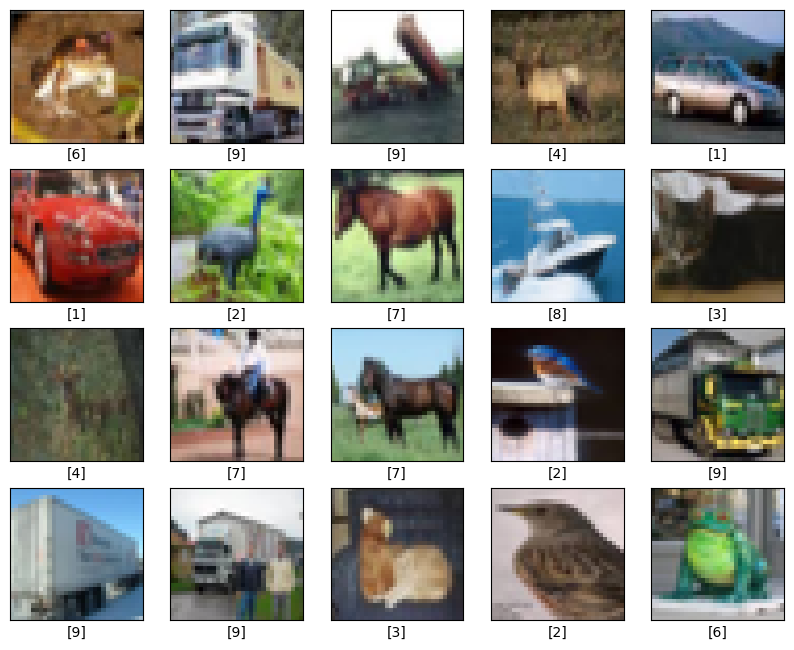

In [51]:
# Explore the data
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(y_train[i])
plt.show()

In [52]:
# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

In [53]:
# explore the data
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)
print("All Labels: ", np.unique(y_train))


x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) y_test shape: (10000, 1)
All Labels:  [0 1 2 3 4 5 6 7 8 9]


In [54]:
# select 10% of the training data to be validation data and another 10% for grid search
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
x_train, x_grid, y_train, y_grid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [55]:
# Build the model
input_dim = x_train.shape[1]

In [56]:

def defin_model(activation='relu', neurons=512, dropout=0.2, optimizer='adam',init_weights='glorot_uniform',weight_constraint=0):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation, kernel_initializer=init_weights, kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

   

In [57]:
model = Sequential()
# add 20 layers of 100 neurons each using swish and he_normal initialization
model.add(Flatten(input_shape=(32, 32, 3)))
for _ in range(20):
    model.add(Dense(100, activation='swish', kernel_initializer='he_normal'))

model.add(Dense(10, activation='softmax'))

In [58]:
opt = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [59]:
# call backs for early stopping and saving the best model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [es, mc, tensorboard_cb]

In [60]:
# train the model
start = time.time()
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=callbacks)
end = time.time()
print("Time taken to train the model: ", end-start)

Epoch 1/100
1121/1125 [============================>.] - ETA: 0s - loss: 2.0335 - accuracy: 0.2443
Epoch 1: val_accuracy improved from -inf to 0.31280, saving model to best_model.h5
1125/1125 [==============================] - 15s 8ms/step - loss: 2.0331 - accuracy: 0.2444 - val_loss: 1.8584 - val_accuracy: 0.3128
Epoch 2/100
1125/1125 [==============================] - ETA: 0s - loss: 1.8006 - accuracy: 0.3394
Epoch 2: val_accuracy improved from 0.31280 to 0.36300, saving model to best_model.h5
1125/1125 [==============================] - 8s 7ms/step - loss: 1.8006 - accuracy: 0.3394 - val_loss: 1.7609 - val_accuracy: 0.3630
Epoch 3/100
1120/1125 [============================>.] - ETA: 0s - loss: 1.7256 - accuracy: 0.3688
Epoch 3: val_accuracy improved from 0.36300 to 0.37780, saving model to best_model.h5
1125/1125 [==============================] - 11s 10ms/step - loss: 1.7254 - accuracy: 0.3689 - val_loss: 1.7067 - val_accuracy: 0.3778
Epoch 4/100
1124/1125 [=======================